In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from collections import defaultdict
from collections import Counter
from PIL import Image


In [2]:
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset:", path)

Path to dataset: C:\Users\jli20\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [3]:
def convert_all_to_rgb(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(file_path)
            except Exception as e:
                print(f"Failed on {file_path}: {e}")

In [6]:
data_path = os.path.join(path, 'data')
subfolders = os.listdir(data_path)
print("Class folders:", subfolders)
convert_all_to_rgb(data_path)

Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [7]:
img_size = (224, 224)
batch_size = 16

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)

unbatched_ds = dataset.unbatch()

class_names = dataset.class_names
print("Class names:", class_names)

Found 5631 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [8]:
"""
{
  'cloudy': [(img1, lbl1), (img2, lbl2)]
  'desert': [.......]
  ......
}
"""

class_datasets = defaultdict(list)

for image, label in unbatched_ds:
    class_idx = int(label.numpy())
    class_name = class_names[class_idx]
    class_datasets[class_name].append((image, label))

In [9]:
def make_class_dataset(data_tuples, batch_size):
    imgs, labels = zip(*data_tuples)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
cloudy_ds = make_class_dataset(class_datasets["cloudy"], batch_size)
desert_ds = make_class_dataset(class_datasets["desert"], batch_size)
green_ds  = make_class_dataset(class_datasets["green_area"], batch_size)
water_ds  = make_class_dataset(class_datasets["water"], batch_size)

In [11]:
def count_images(dataset):
    return sum(1 for _ in dataset.unbatch())

In [12]:
print("Cloudy images:", count_images(cloudy_ds))
print("Desert images:", count_images(desert_ds))
print("Green images:", count_images(green_ds))
print("Water images:", count_images(water_ds))

Cloudy images: 1500
Desert images: 1131
Green images: 1500
Water images: 1500


In [13]:
for image, label in cloudy_ds.take(1):
    print("Min:", tf.reduce_min(image).numpy())
    print("Max:", tf.reduce_max(image).numpy())
    print("Mean:", tf.reduce_mean(image).numpy())

Min: 58.42351
Max: 235.92857
Mean: 149.92747


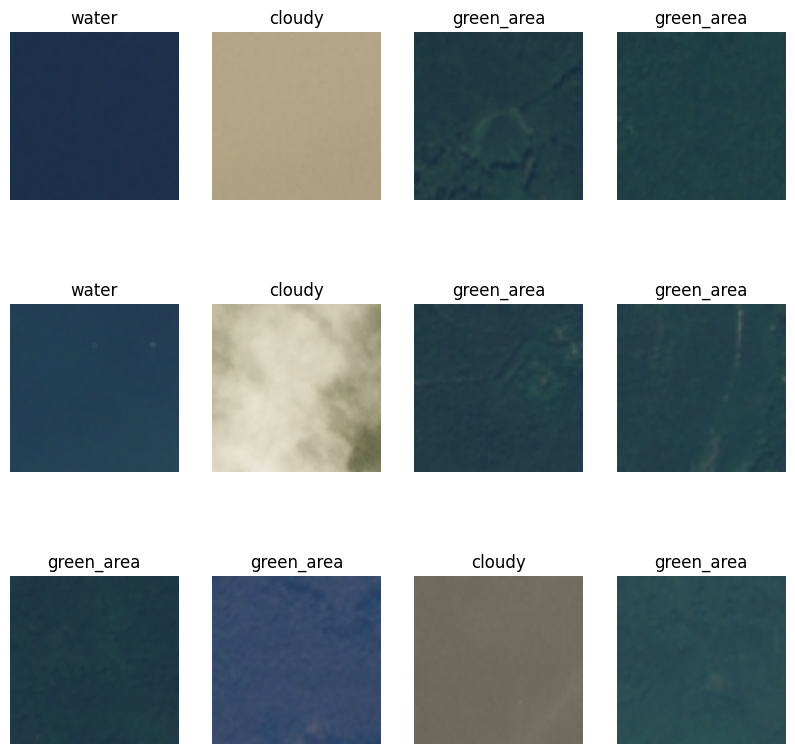

In [14]:
class_names = dataset.class_names

number_of_images = 12

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(number_of_images//4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,      # 20% for validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Train images:", tf.data.experimental.cardinality(train_ds).numpy() * 16)
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Val images:", tf.data.experimental.cardinality(val_ds).numpy() * 16)



Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Train batches: 282
Train images: 4512
Val batches: 71
Val images: 1136


In [16]:
def count_class_number(dataset):
    train_counter = Counter()

    for _, label in dataset.unbatch():
        train_counter[int(label.numpy())] += 1

    # Map class indices to names
    class_names = dataset.class_names
    train_distribution = {class_names[i]: count for i, count in train_counter.items()}

    print("Training set class distribution:")
    for k, v in train_distribution.items():
        print(f"{k}: {v}")

In [17]:
shuffled_cloudy = (
    cloudy_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_green = (
    green_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_desert = (
    desert_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_water = (
    water_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
print(type(water_ds))
print(type(shuffled_water))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


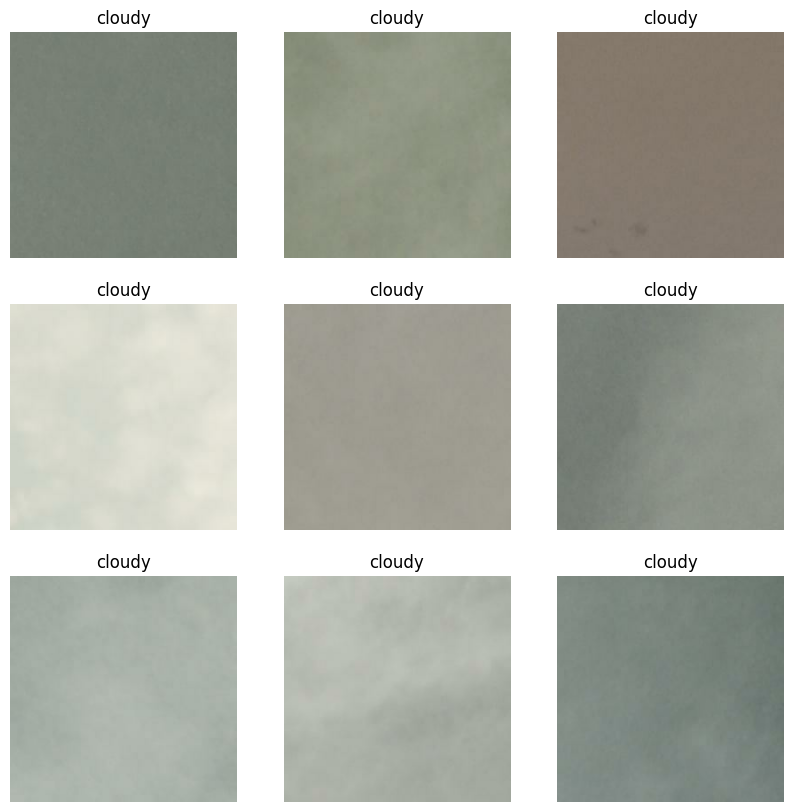

In [19]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_cloudy.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

In [44]:
pre_split_cloudy = list(shuffled_cloudy.unbatch())
pre_split_green = list(shuffled_green.unbatch())
pre_split_water = list(shuffled_water.unbatch())
pre_split_desert = list(shuffled_desert.unbatch())

In [46]:
def relabel(data, new_label):
    return [(img, tf.constant(new_label)) for (img, _) in data]

cloudy = relabel(pre_split_cloudy, 0)
desert = relabel(pre_split_cloudy, 1)
green  = relabel(pre_split_green, 2)
water  = relabel(pre_split_water, 3)

In [47]:
def dataset_split(data, train_ratio):
    i = int(len(data) * train_ratio)
    return data[:i], data[i:]

In [48]:
cloudy_train, cloudy_val = dataset_split(pre_split_cloudy, 0.8)
green_train, green_val = dataset_split(pre_split_green, 0.8)
water_train, water_val = dataset_split(pre_split_water, 0.8)
desert_train, desert_val = dataset_split(pre_split_desert, 0.8)


In [50]:
train_data = cloudy_train + desert_train + green_train + water_train
val_data   = cloudy_val + desert_val + green_val + water_val

In [51]:
def to_tf_dataset(data, batch_size):
    imgs, labels = zip(*data)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [52]:
batch_size = 16
train_ds = to_tf_dataset(train_data, batch_size)
val_ds   = to_tf_dataset(val_data, batch_size)

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

c:\Users\jli20\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
label_counts = Counter()

for _, label in train_ds.unbatch():
    label_counts[int(label.numpy())] += 1

print("Training label distribution:")
for class_index, count in label_counts.items():
    print(f"Class {class_index}: {count} samples")

Training label distribution:
Class 0: 1200 samples
Class 1: 904 samples
Class 2: 1200 samples
Class 3: 1200 samples


In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 126s 400ms/step - accuracy: 0.9453 - loss: 4.6120 - val_accuracy: 0.2662 - val_loss: 127.7154
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 365ms/step - accuracy: 0.8218 - loss: 12.4830 - val_accuracy: 0.2662 - val_loss: 10.8431
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 105s 372ms/step - accuracy: 0.6224 - loss: 2.2549 - val_accuracy: 0.2662 - val_loss: 16.5615
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 105s 372ms/step - accuracy: 0.3935 - loss: 4.0670 - val_accuracy: 0.2662 - val_loss: 1.3927
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 369ms/step - accuracy: 0.0972 - loss: 1.4504 - val_accuracy: 0.2662 - val_loss: 1.3872
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 369ms/step - accuracy: 0.0657 - loss: 1.4378 - val_accuracy: 0.2662 - val_loss: 1.3849
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 104s 370ms/step - accuracy: 0.0696 - loss: 1.4321 - val_accuracy: 0.2662 - val_loss: 1.3835
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - accuracy: 0.0

KeyboardInterrupt: 